In [1]:
from ast import literal_eval
from itertools import groupby
from operator import itemgetter

import pandas as pd
from plotnine import *


pd.set_option("display.max_colwidth", None)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

## Exploratory Data Analysis

In [3]:
trainset = pd.read_csv("../data/tsd_train.csv")

inspect_df(trainset)

shape: (7939, 2)


,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]",Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junior pal. What you are saying makes no sense. I don't know what you are basing this on. The cheap black market crap is still coming up from Mexican nationals, and the good stuff from BC and Humbolt. The I5 corridor is still just as busy, and they are still making a ton of money. Nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it. And the legal market is controlled by corporate growers with million dollar facilities, or a co-op of smaller growers. The Federal government ""war on drugs"" really has no impact on the legal market in Oregon. I don't see any glutton of weed, whatever that means."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know this would be offensive??
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\r\n\r\nAnyone and everyone. This is a community problem, so everyone who wants to be part of the solution should be allowed to help. As I said above: remove all protections on free ranging cats, and allow people to help. People who allow their pets to roam outside are part of the problem, because their pets are part of the problem. It would be very sad if pets were killed, but ultimately it is the owner's responsibility to make sure their pets are not out killing birds.\r\n\r\nYears ago some Vermont acquaintances got one warning from the Ranger: Next time I see your dog running deer, I'll shoot it. Next time she saw it running deer, she did. \r\n\r\nVermont does not pretend that trapping, neutering, and releasing dogs solves any problems. They are serious about threats. We just want to feel good about ourselves. If we were serious about feral cats, we would kill them. Neutered cats eat birds. Don't release them. Kill them."


In [4]:
# we will deserialize `spans` from str instances to proper objects (lists)
try:
    trainset["spans"] = trainset["spans"].apply(literal_eval)

except ValueError:  # in case cell is executed more than once
    pass

In [5]:
# how many data points contain toxic spans?
toxic = trainset["spans"].apply(len) > 0

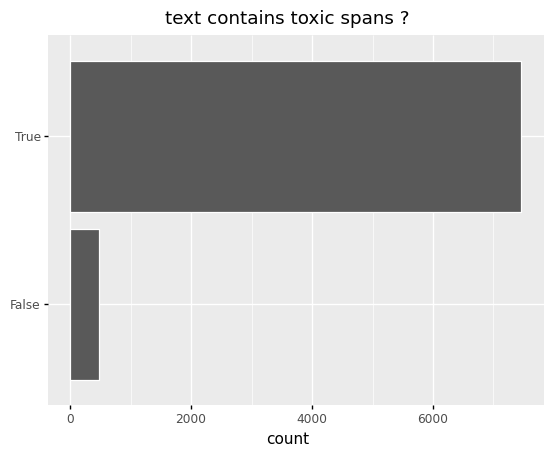

<ggplot: (135706257634)>

In [6]:
(
    ggplot()
    + geom_bar(mapping=aes(x=toxic), colour="white")
    + labs(title="text contains toxic spans ?", x="")
    + coord_flip()
)

In [7]:
# some non-toxic documents
inspect_df(trainset[~toxic])

shape: (485, 2)


,spans,text
5,[],"But, but, but, is NOT a defense. It's not even a good deflection. In America today we have Nazis waving the Nazi flag at rallies in our cities. In what capacity does anyone think this is ok and who would not see that as a problem?\r\n\r\nEnough with the ""Well what about blah blah"" garbage."
21,[],"Jim\r\n\r\nI think Donald is a con man and a dangerous, narcissistic buffoon. But I don't hate Donald. He's not worth the emotional effort needed to hate. To say I hate him is to admit that I even care about him, which I don't. What I do care about is the damage he's already caused to this country, and the continuing damage he'll cause to this country and the world until he leaves office."
24,[],Exposing hypocrites like Trump and Pence is therapeutic for you? Good job!
27,[],"The malignant narcissist, mentally deranged sociopath, bigot, rascist, disingenuous blowhard and pathological liar, has now certified himself as a fascist. How much longer before his GOP sycophants and suckees say, ""Enough!"", and demand this repugnant, excrement-spewing fool's ouster?"
60,[],"the is NO CONSENSUS you ignorant loser, NONE, nothing but debate, thousands of scientist do not agree period, we dont need to move from anything other than left wing stupidity like yours."


We can observe that, although these 485 texts do not have toxic spans as annotation, some of them clearly contain toxic words, phrases etc.

In [8]:
trainset["text"].map(len).describe()

count    7939.000000
mean      205.269807
std       202.184623
min         4.000000
25%        72.000000
50%       136.000000
75%       263.000000
max      1047.000000
Name: text, dtype: float64

The average document in the training dataset has 204 characters, the shortest one is only 4 characters while the largest one is 1000. 

In [9]:
trainset[toxic]["spans"].map(len).describe()

count    7454.000000
mean       18.663134
std        46.955908
min         2.000000
25%         6.000000
50%         9.000000
75%        16.000000
max       994.000000
Name: spans, dtype: float64

The average toxic document in the training dataset has ~19 toxic characters (i.e. characters belonging to toxic character sequences).

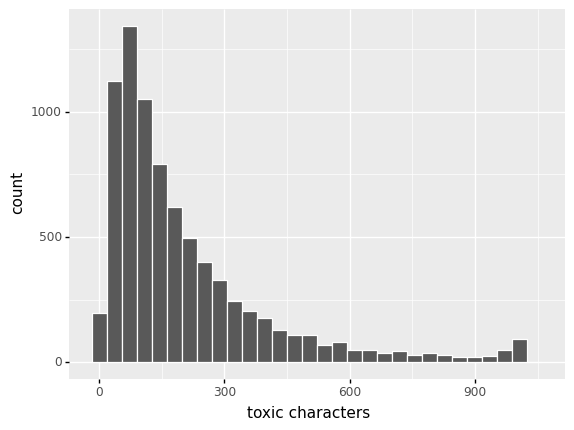

<ggplot: (135706257607)>

In [10]:
(
    ggplot()
    + geom_histogram(mapping=aes(x=trainset["text"].map(len)), colour="white", bins=30)
    + xlab("toxic characters")
)

We can observe that in a typical span, let's say:

$$ [ 3, 4, 5, 6, 44, 45, 46 ] $$

groups of consequtive integers ($ 3 \rightarrow 6, 44 \rightarrow 46$) are basically individual character sequences.

Based on that, we can also get a peek on the number of toxic character sequences in the training dataset.

In [11]:
def continuous_spans(iterable: list):
    """Yield groups of continuous spans from an `iterable`.

    Example:

        iterable: [10, 11, 12, 13, 14, 15, 51, 52, 53, 54, 55, 56]

        Returns: an iterator of groups. Each group is itself an iterator that materializes in a continuous span:
                     1. [10, 11, 12, 13, 14, 15]
                     2. [51, 52, 53, 54, 55, 56]

    Inspired by: https://more-itertools.readthedocs.io/en/stable/api.html#more_itertools.consecutive_groups
    """
    for _, g in groupby(enumerate(iterable), key=lambda x: x[0] - x[1]):
        yield map(itemgetter(1), g)

In [12]:
charsequences = trainset[toxic]["spans"].apply(
    lambda x: [list(charseq) for charseq in continuous_spans(x)]
)

In [13]:
charsequences.map(len).describe()

count    7454.000000
mean        1.381540
std         0.791483
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: spans, dtype: float64

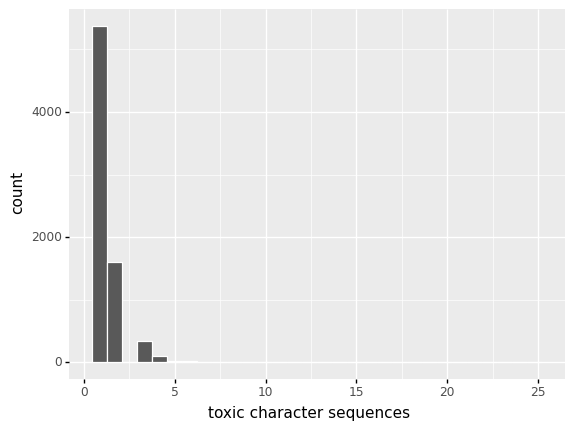

<ggplot: (135707055285)>

In [14]:
(
    ggplot()
    + geom_histogram(mapping=aes(x=charsequences.map(len)), colour="white", bins=30)
    + xlab("toxic character sequences")
)

So, a typical toxic document of the training dataset is likely to have 1 or 2 character sequences that attribute to its toxicity.

## The Learning Task

Our [objective](https://competitions.codalab.org/competitions/25623#learn_the_details-overview) here is to train a suitable model that will be able to predict the toxic spans -if any- contained in new, unseen documents.

This is a binary sequence labelling task.

## A First Baseline Model

To better understand the difficulty for this learning, we will create a basic random sequence labeller and assess its performance.

In [15]:
import random


random.seed(a=42)


class RandomSequenceLabeller(object):
    """Random sequence labeller - returns toxic offsets at random."""

    def predict(self, doc: str) -> list:

        return [i for i, ch in enumerate(doc) if random.random() > 0.5]

In [16]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1

    Originally in: https://github.com/ipavlopoulos/toxic_spans/blob/master/evaluation/semeval2021.py
    """
    if len(gold) == 0:
        return 1.0 if len(predictions) == 0 else 0.0

    if len(predictions) == 0:
        return 0.0

    predictions_set = set(predictions)
    gold_set = set(gold)

    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)

    return float(nom) / float(denom)

In [17]:
# fetch the validation set
validationset = pd.read_csv("../data/tsd_trial.csv")
validationset["text"] = validationset["text"].apply(str.lower)

try:
    validationset["spans"] = validationset["spans"].apply(literal_eval)

except ValueError:  # in case cell is executed more than once
    pass

In [18]:
validationset["text"].loc[11]

'trump said, in as many words, that mexicans were rapists and drug dealers.'

In [19]:
random_model = RandomSequenceLabeller()

a_prediction = random_model.predict(doc=validationset["text"].loc[11])

In [20]:
f1(a_prediction, gold=validationset["spans"].loc[11])

0.5

In [21]:
# and now for the whole validation dataset
valset = validationset.copy()  # TODO: Why copy?

valset["random_predictions"] = valset["text"].apply(random_model.predict)
valset["f1_score"] = valset.apply(
    lambda s: f1(s.random_predictions, gold=s.spans), axis=1
)

inspect_df(valset)

shape: (690, 4)


,spans,text,random_predictions,f1_score
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",because he's a moron and a bigot. it's not any more complicated than that.,"[0, 2, 6, 8, 9, 12, 13, 17, 18, 22, 23, 24, 25, 27, 28, 29, 31, 35, 36, 38, 40, 41, 43, 44, 46, 47, 48, 49, 53, 54, 55, 58, 59, 63, 64, 67, 69, 72, 73]",0.244898
1,"[29, 30, 31, 32, 33, 34]",how about we stop protecting idiots and let nature add some bleach to the gene pool. we can always submit their names for the darwin awards.,"[2, 3, 5, 9, 13, 15, 16, 19, 22, 23, 25, 26, 32, 33, 34, 38, 45, 47, 48, 50, 51, 52, 53, 54, 61, 63, 66, 67, 68, 69, 72, 73, 74, 75, 77, 78, 79, 81, 84, 85, 88, 90, 91, 93, 94, 95, 97, 100, 103, 106, 107, 111, 112, 113, 116, 117, 118, 119, 120, 122, 124, 125, 129, 131, 132, 134, 137, 138]",0.081081
2,"[166, 167, 168, 169, 170, 171]","if people were smart, they would boycott this inept airline, but they are not smart, so rogue businesses like this one, still thrive taking the idiots for a ride...","[3, 4, 6, 7, 11, 12, 13, 14, 15, 19, 20, 21, 22, 26, 27, 29, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 44, 46, 47, 49, 52, 57, 58, 60, 62, 63, 64, 66, 68, 72, 74, 75, 77, 79, 81, 82, 83, 84, 85, 88, 91, 92, 100, 101, 102, 103, 105, 109, 110, 115, 116, 119, 120, 122, 123, 124, 130, 133, 135, 138, 140, 141, 145, 146, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 167, 168, 169, 170, 176, 179, 180, 183, 187]",0.077670
3,"[87, 88, 89, 90, 91, 92]","trump claimed that russia will never invade the ukraine, when russia already has - how stupid can people be?","[0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 19, 24, 27, 29, 36, 38, 39, 43, 44, 46, 47, 48, 49, 50, 55, 56, 58, 59, 61, 62, 64, 65, 69, 70, 72, 74, 75, 77, 78, 79, 81, 82, 86, 88, 89, 91, 92, 93, 94, 96, 97, 99, 100, 103, 105, 106]",0.129032
4,[],"as long as your willing to pay a lot more for products you buy, then fine.\r\nbut you better not be going to costco and walmart to buy stuff because it's cheaper.\r\nif so, we get to call you a hypocritical wanker.","[0, 3, 6, 9, 11, 12, 15, 17, 19, 20, 21, 23, 26, 28, 30, 32, 34, 40, 41, 45, 46, 47, 54, 56, 57, 58, 60, 62, 63, 68, 70, 73, 76, 78, 80, 81, 82, 84, 87, 88, 90, 91, 92, 93, 96, 102, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 122, 123, 126, 127, 128, 129, 137, 138, 139, 140, 141, 142, 145, 147, 148, 150, 151, 156, 157, 159, 161, 162, 163, 167, 169, 170, 171, 172, 176, 177, 178, 180, 181, 183, 185, 186, 189, 190, 192, 193, 196, 198, ...]",0.000000


In [22]:
valset["f1_score"].mean()

0.17281838692870177

So, averaging over the test dataset, our random classifier achieves an F1 score of approx. 17%.